# How to use Azure to do Style Transfer on a Video

This tutorial will take you through how to take a video, and apply style transfer onto every frame of the video, using Azure.

## (Optional) Tuning the style transfer hyperparameters interactively

The first thing we want to do is to test the style transfer scripts locally and make sure the hyper parameters are set appropriately. This will be done using the __style_transfer_interactive.ipynb__ notebook.

Open the notebook __/pytorch/style_transfer_interactive.ipynb__ and tune the variables following variables as desired: 

- STYLE_WEIGHT = 10**8
- CONTENT_WEIGHT = 10**0
- NUM_STEPS = 100
- IMAGE_SIZE = (between 300-600px if GPU enabled)

*the defaults shown above _tend_ to work nicely for most images.

## Style Transfer: Testing the style transfer script locally

In this first section, we'll test our __style_transfer_script.py__ locally and inspect the results to see that our output images look as expected. (If they're not, we should tun the parameters in the script so that the output images look the way we want them to).

The __style_transfer_script.py__ is essentially the __.py__ version of the __style_transfer_interactive.ipynb__ from above. 

Lets start by taking a look at the style image whose style we'd like to apply onto other images:

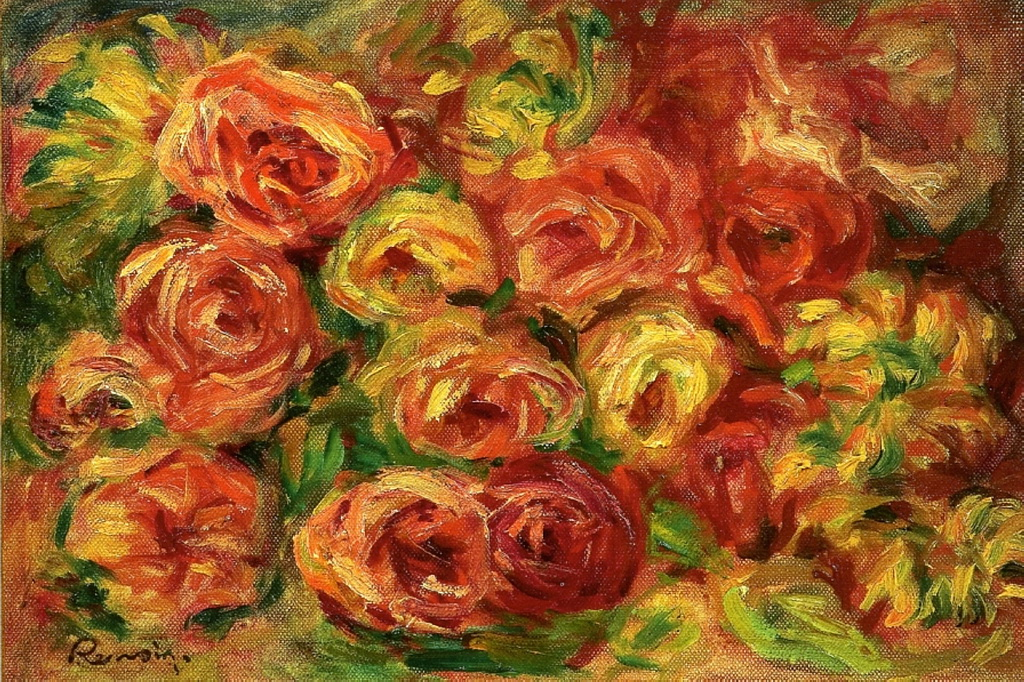

In [1]:
from IPython.display import Image
import os
im1 = Image(filename="pytorch/images/style_images/sample_renior.jpg", width=360)
display(im1)

Lets also take a look at a sample content image that we'll apply the style transfer onto:

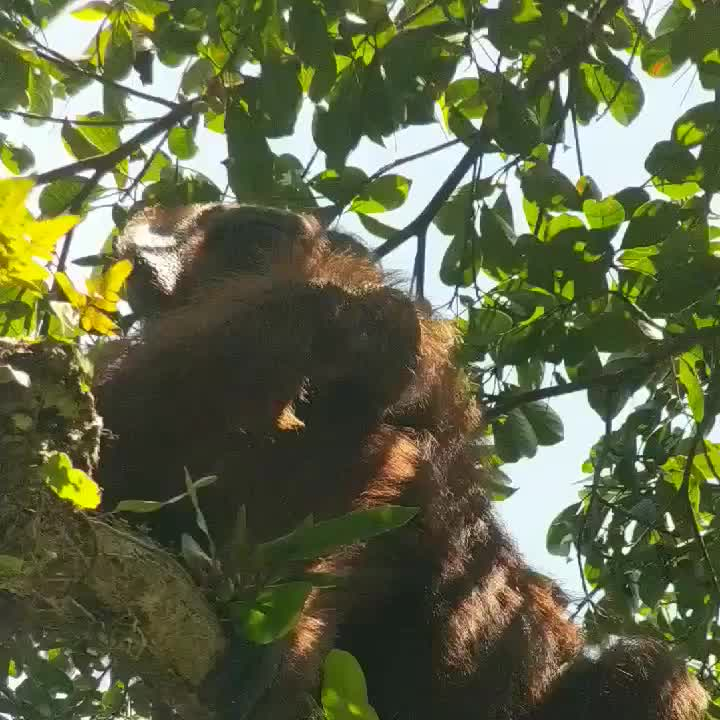

In [2]:
from IPython.display import Image
import os
im1 = Image(filename="pytorch/images/sample_content_images/sample_0.jpg", width=360, height=360)
display(im1)

Then we need to create the directory to store the output images.

In [3]:
%%bash
mkdir pytorch/images/sample_output_images

mkdir: cannot create directory ‘pytorch/images/sample_output_images’: File exists


If you changed the hyperparameters in the above section and would like to apply it, you can use the following variables: `--style-weight`, `--content-weight`, `--image-size`, and/or `--num-steps`

In [1]:
%%bash
cd pytorch &&
    python style_transfer_script.py \
    --style-image ./images/style_images/sample_renior.jpg \
    --content-image-dir ./images/sample_content_images \
    --content-image-list 'sample_0.jpg' \
    --output-image-dir ./images/sample_output_images \
    --style-weight $STYLE_WEIGHT \
    --content-weight $CONTENT_WEIGHT \
    --num-steps $NUM_STEPS \
    --image-size $IMAGE_SIZE \
    --log-file 'sample_style_transfer_script'

2018-09-17 20:23:47,841 - __main__ - DEBUG - Images to process: 1
2018-09-17 20:23:47,842 - __main__ - DEBUG - GPU detected: True, image size: 512
2018-09-17 20:23:50,936 - __main__ - DEBUG - Time (in seconds) to load style image: 3.094032
2018-09-17 20:23:57,700 - __main__ - DEBUG - Time (in seconds) to load VGG19 model: 6.763897
2018-09-17 20:23:57,754 - __main__ - DEBUG - Running Style Transfer on sample_0.jpg
2018-09-17 20:24:07,585 - __main__ - DEBUG - Time (in seconds) to apply style-transfer to batch of 1 images: 9.884242
2018-09-17 20:24:07,585 - __main__ - DEBUG - Average Time (in seconds) to apply style-transfer to each image: 9.884242


We can now inspect the output directory to make sure that the output images are there.

In [ ]:
%%bash
ls pytorch/images/sample_output_images

Lets see what one of those images look like in comparison to the original content image:

In [ ]:
from IPython.display import Image
import os
im1 = Image(filename="pytorch/images/sample_output_images/sample_0.jpg")
im2 = Image(filename="pytorch/images/sample_content_images/sample_0.jpg", width=360, height=360)
display(im1, im2)

Looks great! At this point, we know that the __style_transfer_script.py__ file that we'll be running in Azure works as expected.

## Setup your video for batch style transfer

The next step is to set up the video so that we can apply transfer onto all of the frames in the video.

### Download Video: 

The first thing we need to do is to download a video that we would like to apply style transfer onto. To do so, we'll download a short climbing video that I preloaded into a public Blob Storage, located at:
- https://happypathspublic.blob.core.windows.net/videos/

*Feel free to manually place your own video (mp4) file into that directory instead of downloading my _lovely_ orangutan video...

In [ ]:
%%bash
mkdir pytorch/video

In [ ]:
%set_env VIDEO_NAME=orangutan

In [ ]:
%%bash
cd pytorch/video && 
    wget https://happypathspublic.blob.core.windows.net/videos/${VIDEO_NAME}.mp4

Lets check out the video so we know what it looks like before hand:

In [ ]:
from IPython.display import HTML
import os
HTML('\
    <video width="360" height="360" controls> \
         <source src="pytorch/video/{0}.mp4" type="video/mp4"> \
    </video>'\
    .format(os.getenv('VIDEO_NAME'))
)

### Pre-process video with ffmpeg

Next we need to use __ffmpeg__ to extract the audio file, which we will save as __chicken.aac__ under the video directory.

In [ ]:
%%bash 
cd pytorch/video &&
    ffmpeg -i ${VIDEO_NAME}.mp4 ${VIDEO_NAME}.mp3

Finally, we need break up the frames of the video into separate individual images. The images will be saved inside a new folder under the images directory, called __chicken_frames__.

In [ ]:
%%bash
cd pytorch/images/ &&
    mkdir ${VIDEO_NAME} && cd ${VIDEO_NAME} &&
    ffmpeg -i ../../video/${VIDEO_NAME}.mp4 %05d_${VIDEO_NAME}.jpg -hide_banner

We can count the number of frames that the video produced:

In [ ]:
%%bash
cd pytorch/images/${VIDEO_NAME} && ls -1 | wc -l

At this point, our file system should have the following under the folder __pytorch_style_transfer__:
```md
├── images/
│   ├── video_name/ [<--new dir with video frames as images]
│   ├── sample_content_images/
│   ├── sample_output_images/
│   └── style_images/
├── video/
│   ├── video_name.mp4 [<--new video]
│   └── video_name.mp3 [<--new extracted audio file for video]
├── style_transfer_interactive.ipynb
└── style_transfer_script.py
```

Now that we have all the frames of the video stored seperately as images, we are ready to scale out and try scoring in the cloud.

## Testing our Style Transfer Script on Azure BatchAI

In this tutorial, we use Azure BatchAI to scale out of computation to multiple GPUs in Azure.

### Setting up your cluster

First, we need to create your cluster using the __azure/scripts/create_cluster.py__ script.

This script will create the BatchAI workspace for all BatchAI resources to be created in.

After running this command, go into the Azure portal and check that your cluster is successfully created.

In [ ]:
%%bash 
python azure/scripts/create_cluster.py

### Upload files into Azure Blob Storage

Now we need to upload the script and model files to the fileshare using __az_copy__. We'll also upload our content images to test our Batch AI jobs. 

After running this command, go into the Azure portal or the Azure Storage Explorer and make sure that the files are correctly uploaded.

In [ ]:
%%bash
azcopy \
    --source pytorch/style_transfer_script.py \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/${FS_INPUT_DIR}/${FS_SCRIPT_NAME} \
    --dest-key $STORAGE_ACCOUNT_KEY
    
azcopy \
    --source pytorch/images/style_images/sample_renior.jpg \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/${FS_INPUT_DIR}/${FS_STYLE_IMG_NAME} \
    --dest-key $STORAGE_ACCOUNT_KEY
    
azcopy \
    --source pytorch/images/${VIDEO_NAME} \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/${FS_CONTENT_DIR} \
    --dest-key $STORAGE_ACCOUNT_KEY \
    --recursive

### Create a Test job

Finally, lets test that our style transfer script works on the Batch AI cluster. Use the __azure/scripts/create_job.py__ script to kick off a job. 

Kicking off this job will also automatically create 2 additional folders in your Blob container. The first folder will be named __output_of_content_YYYY_MM_DD_HHMMSS__ and the second will be named __logs_of_content_YYYY_MM_DD_HHMMSS__. The style transfer script will automatically save all output of the style transfer to the first folder. And likewise, all logs collected from the style transfer script will be saved to the second folder.

NOTE - this command could take a while to execute. Remember that this will apply style transfer onto each frame of the video - this means that the code will optimize the style transfer loss function for every frame. 

After running this command, go into the Azure portal under your BatchAI account to make sure the job is sucessfully created.

In [ ]:
%%bash
python azure/scripts/create_job.py --job-batch-size 50

### Inspect the results

When the jobs finish running, you can use the Azure portal or Storage explorer to inspect the output images.

Inside your Blob Container, you should notice that a new directory with the datetime-stamp is created. Output images are stored there.

## Running it with Docker

After we've tested that the BatchAI jobs are successfully created, we now want to build a docker container and check that we can run the BatchAI job from a docker container.

First we need to build the docker image using the Dockerfile which will upload all Azure utility python files as well as the __create_job.py__ file into the image.

In [ ]:
%%bash
cd azure &&
    sudo docker build -t $DOCKER_IMAGE .

[Optional] 

Then we test that the BatchAI job can be executed from the docker image we just built. Because the __create_job.py__ file requires many environment variables, we will use the __docker_run.sh__ script to pass in all the required environment variables for the image to successfully run locally. This step is optional as it will take several minutes to run the job.

In [ ]:
%%bash
cd azure &&
    source docker_run.sh -t $DOCKER_IMAGE

Finally, we have to publish the image to Dockerhub. _Make sure you replace <your-dockerhub-username>_ with your Dockerhub username. Don't forget that you'll have to make sure you're already logged in before being able to push your image up. (`docker login`)

In [ ]:
%%bash
cd azure &&
    sudo docker tag $DOCKER_IMAGE $DOCKER_USER/$DOCKER_IMAGE &&
    sudo docker push $DOCKER_USER/$DOCKER_IMAGE

## Setting up ACI with Logic Apps

First we need to generate the ARM deployment template for deploying ACI and Logic App to set up the trigger. We will use the __generate_trigger_arm.py__ script to generate an ARM Template (JSON) which we can use to deploy the ACI and Logic App. The script uses __azure/deployments/template.trigger_arm.json__ to generate __azure/deployments/trigger_arm.json__, which we can use to execute the deployment.

If you inspect the ARM Template, you'll see that Logic App will be triggered when a new file is added to the blob. The trigger will only occur if the blob filename begins with 'trigger' and ends with '.txt'. It will then use the contents of the blob to look for the corresponding directory in that Blob Container, which it then uses as the content image file directory for the transfer.

For example, if we upload a file, titled `trigger_0.txt`, with the content "content_image_dir", the Logic App will look for a directory in the Blob Container titled "content_image_dir", and start to process the images it finds in the directory.

First lets generate the trigger template:

In [ ]:
%%bash
cd azure/arm &&
    python ../scripts/generate_trigger_arm.py trigger_arm.json

Lets also just make sure that you've set the correct subscription in the __az cli__.

In [ ]:
%%bash
az account set -s $SUBSCRIPTION_ID

Now lets use the __az cli__ to deploy the solution.

In [ ]:
%%bash
az group deployment create \
    --name aci_logicapp_deployment \
    --resource-group $RESOURCE_GROUP \
    --template-file azure/arm/trigger_arm.json

## Trigger the process

Finally we need to trigger the process by loading something into blob. Normally, this can be done with any process (such as drag-and-drop using Storage Explorer), but for the purposes of this demo, lets do so simply with __az_copy__.

First we create a file, __foo.txt__ with the contents being the name of the directory in the blob that we want to apply style transfer too.

In [ ]:
%%bash
touch trigger_0.txt &&
    echo $FS_CONTENT_DIR > trigger_0.txt

Next we have to copy that file over to storage to trigger the process:

In [ ]:
%%bash
azcopy \
    --source trigger_0.txt \
    --destination https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME}/trigger_0.txt \
    --dest-key $STORAGE_ACCOUNT_KEY

We can now inspect the logs from ACI to see that everything is going smoothly:

In [ ]:
%%bash
az container logs --resource-group $RESOURCE_GROUP --name $ACI_CONTAINER_GROUP

At this point, we can inspect the Azure portal to see all the moving parts:
- Logic Apps will be triggers and will spin up ACI
- ACI will break up the content images in blob and create BatchAI jobs
- The BatchAI cluster will scale up and start processing the work
- As the style transfer script is executed in batch on BatchAI, we will see the completed images (as well as logs) saved back to blob 

## Download Results and Re-stitch Video

The last step is to download and restitch the video so that we can enjoy the same video, but now with each frame with style transfer applied.

First we need to get the name of the output folder where all out style transfered frames are stored. We do this by using the Batch AI CLI. We store the name of the output folder as `output_folder_name` to be used in later cells.

In [ ]:
import os

# We use `--query [-1].name` to mean: 'get the name of the last experiment'
exp_names = !az batchai experiment list -g ${RESOURCE_GROUP} --workspace ${WORKSPACE} --query [-1].name

# strip quotation marks
exp_name = str(exp_names[0])[1:-1]

# replace experiment prefix with output folder prefix
exp_name_array = str(exp_name).split('_')
exp_name_array[0] = "{0}_{1}".format(os.getenv('FS_OUTPUT_DIR_PREFIX'), os.getenv('FS_CONTENT_DIR'))
output_folder_name = '_'.join(exp_name_array)

Using the `output_folder_name` variable, lets download the frames:

In [ ]:
%%script env output_folder_name="$output_folder_name" bash
cd pytorch/images &&
    azcopy \
        --source https://${STORAGE_ACCOUNT_NAME}.blob.core.windows.net/${AZURE_CONTAINER_NAME} \
        --destination . \
        --source-key $STORAGE_ACCOUNT_KEY \
        --include $output_folder_name \
        --recursive

Then lets use ffmpeg to stitch independent frames back into a video.

In [ ]:
%%script env output_folder_name="$output_folder_name" bash
cd pytorch &&
    ffmpeg \
        -framerate 30 \
        -i images/$output_folder_name/%05d_${VIDEO_NAME}.jpg \
        -c:v libx264 \
        -profile:v high -crf 20 -pix_fmt yuv420p \
        -y \
        video/${VIDEO_NAME}_processed_without_audio.mp4 

In [ ]:
%%bash
cd pytorch/video &&
    ffmpeg -i ${VIDEO_NAME}_processed_without_audio.mp4 -i ${VIDEO_NAME}.mp3 \
        -map 0:0 -map 1:0 \
        -vcodec copy -acodec copy \
        -y \
        ${VIDEO_NAME}_processed_with_audio.mp4

In [ ]:
from IPython.display import HTML
import os
HTML('\
    <video width="360" height="360" controls> \
         <source src="pytorch/video/{0}_processed_with_audio.mp4" type="video/mp4"> \
    </video>'\
    .format(os.getenv('VIDEO_NAME'))
)

In [ ]:
from IPython.display import Image
import os
im1 = Image(filename="pytorch/images/{0}/00001_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
im2 = Image(filename="pytorch/images/{0}/00100_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
im3 = Image(filename="pytorch/images/{0}/00300_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
im4 = Image(filename="pytorch/images/{0}/00500_{1}.jpg".format(output_folder_name, os.getenv('VIDEO_NAME')))
display(im1, im2, im3, im4)

## Delete resources

Its always good to clean up your Azure resources after you've completed your workload.

In [ ]:
%%bash
az group delete --name $RESOURCE_GROUP